# Out-of-Distributin detection on different OoD and with different metrics

In [1]:
import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial


plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import scipy

In [3]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
from pae.model_tf2 import get_prior, get_posterior

In [5]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [6]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file = 'params_fmnist_-1_40_infoGAN_AE_best_params_noaugment_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))


In [7]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5

In [8]:
def get_outliers(dataset,flip='no'):
    if dataset=='omniglot':
        import tensorflow_datasets as tfds
        from skimage.transform import resize
        omni= tfds.load('omniglot')
        glot = tfds.as_numpy(omni)
        samples=[]
        for sample in glot['test']:
            s = resize(sample['image'],(28,28))
            samples.append(-(s-0.5))
        samples=np.asarray(samples)
        samples = np.mean(samples[0:10000],axis=-1)
        x_valid_ood=np.expand_dims(samples,-1)
        x_test_ood=x_valid_ood
    else:
        load_func                                         = partial(load_funcs[dataset])
        x_train_ood, y_train, x_valid_ood, y_valid, x_test_ood, y_test = load_func(params['data_dir'],flatten=False)
        #print(x_test_ood)
        if np.any(x_test_ood)is None:
            x_test_ood=x_valid_ood

        if  flip=='horizontal':
            x_test_ood    = np.asarray([np.fliplr(x) for x in x_test_ood/255.-0.5])
        elif flip=='vertical':
            x_test_ood    = np.asarray([np.flipud(x) for x in x_test_ood/255.-0.5])
        else:
            x_test_ood    = x_test_ood/255.-0.5

    for ii in range(2):
        plt.imshow(np.squeeze(x_test_ood[ii]),cmap='gray')
        plt.axis('off')
        plt.show()
    return x_test_ood

### To reproduce results choose either 'mnist', 'fmnist', or 'omniglot'. To flip use keyword 'horizontal' or 'vertical'

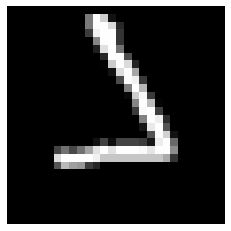

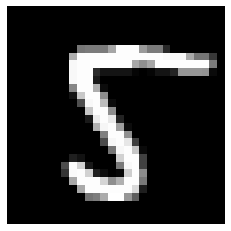

In [39]:
ood_set='mnist'
flip='vertical'
x_valid_ood=get_outliers(ood_set, flip=flip)

In [40]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nf_tag7_90')

In [41]:
def get_likelihood(decoder,sigma):
  
    def likelihood(z):
        mean = decoder({'z':z},as_dict=True)['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

In [42]:
tf.reset_default_graph()

data          = tf.placeholder(shape=params['full_size'],dtype=tf.float32)
MAP_ini       = tf.placeholder_with_default(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),shape=(params['batch_size'],params['latent_size']))
lr            = tf.placeholder_with_default(1e-4,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
sigma         = tf.placeholder_with_default(params['full_sigma'],shape=[28,28,1])
sigma         = tf.cast(sigma,tf.float32)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

likelihood       = get_likelihood(decoder,sigma)
prior            = get_prior(params['latent_size'])
posterior        = get_posterior(encoder)
approx_posterior = posterior(data)

encoded         = approx_posterior.mean()

# here, the MAP lives in z-space
MAP              = tf.Variable(MAP_ini)
MAP_reset        = tf.stop_gradient(MAP.assign(MAP_ini))

#evaluate log prob of z'
MAP_prior        = nvp_funcs({'z_sample':MAP,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
#this is the Gaussian probability in u space (used to isolate log det J)
bwd_pass         = nvp_funcs({'z_sample':MAP,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']
MAP_Gauss        = prior.log_prob(bwd_pass)
# the Jacobian should be the difference
NF_Jac           = MAP_prior - MAP_Gauss

decoded          = likelihood(MAP).mean()
MAP_likelihood   = likelihood(MAP).log_prob(data)

px_tilde         = MAP_likelihood+MAP_prior

recon            = -tf.reduce_mean(tf.square(decoded-data),axis=(1,2))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [43]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Full Measured Sigma, log_post with single sample, Log Likelihood at Encoded and Reconstruction

prior
nats: 7.558366
bits per dim: 0.013908695010702634
AUROC: 0.997


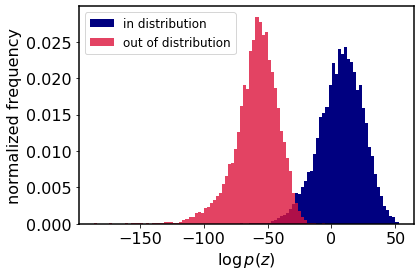

likelihood
nats: -2525.6978
bits per dim: -4.64771890860324
AUROC: 0.958


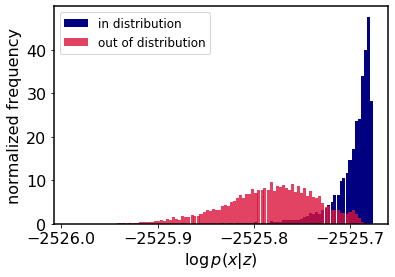

recon_error
nats: -0.0058728904
bits per dim: -1.0807129831951966e-05
AUROC: 0.958


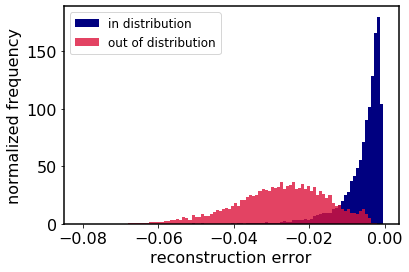

Laplace_without_Volume
nats: -2517.9973
bits per dim: -4.633548773639351
AUROC: 0.997


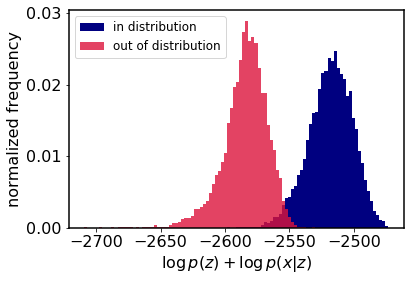

In [44]:
from scipy.integrate import simps

metrics = ['prior','likelihood', 'recon_error', 'Laplace_without_Volume']
labels  = [r'$\mathrm{log}\, p(z)$',r'$\mathrm{log}\, p(x|z)$', 'reconstruction error',r'$\mathrm{log}\, p(z)+\mathrm{log}\, p(x|z)$' ]
objs    = [MAP_prior,MAP_likelihood,recon, px_tilde]


AUROC=[]
false_positive=[]
encoded_oods=[]

sig = np.maximum(params['full_sigma'],10)
for jj in range(len(metrics)):
    print(metrics[jj])
    objective=[]
    encodeds=[]
    for ii in range(len(x_valid)//params['batch_size']):
        data_sample = x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]
        MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
        encodeds+=[MAP_init]
        objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
    MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
    encodeds+=[MAP_init]
    sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
    objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
    objective = np.asarray(objective).flatten()[0:len(x_valid)]
    encodeds =  np.asarray(encodeds).reshape((-1,params['latent_size']))[0:len(x_valid)]
    np.save(os.path.join(params['data_dir'],ood_set+flip+'_AE40_encoded_id.npy'),encodeds)


    objective_ood=[]
    for ii in range(len(x_valid_ood)//params['batch_size']):
        data_sample = x_valid_ood[ii*params['batch_size']:(ii+1)*params['batch_size']]
        MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
        encoded_oods+=[MAP_init]
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
        objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid_ood[(ii+1)*params['batch_size']:len(x_valid_ood)],x_valid_ood[0:params['batch_size']-delta]))
    MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
    encoded_oods+=[MAP_init]
    sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
    objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
    objective_ood = np.asarray(objective_ood).flatten()[0:len(x_valid)]
    encoded_OOD =  np.asarray(encoded_oods).reshape((-1,params['latent_size']))[0:len(x_valid)]
    np.save(os.path.join(params['data_dir'],ood_set+flip+'_AE40_encoded.npy'),encoded_OOD)

    objective = np.asarray(objective)
    objective_ood = np.asarray(objective_ood)
    objs_ = np.sort(objective)
    objs_ood_ = np.sort(objective_ood)
    print('nats:', np.mean(objs_))
    print('bits per dim:', np.mean(objs_)/np.log(2)/(28*28))
    false_pos=[]
    true_pos=[]
    for ii in range(10000):
        val = objs_[ii]
        true_pos.append(len(np.where(objs_>=val)[0])/len(objs_))
        false_pos.append(len(np.where(objs_ood_>=val)[0])/len(objs_))
    false_pos = np.asarray(false_pos,dtype=np.float64)
    AUROC+=[1-np.sum(false_pos)*1./np.float(len(objs_))]
    print('AUROC:',np.round(AUROC[-1],3))
    mini = min(min(np.sort(objective)[2:]),min(np.sort(objective_ood)[2:]))
    maxi = max(max(objective),max(objective_ood))
    plt.figure()
    _ = plt.hist(objective, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(objective_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(labels[jj])
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+flip+'_'+metrics[jj]+'.pdf'),bbox_inches='tight')
    plt.show()
false_positive.append(false_pos)

In [45]:
path = '/global/cscratch1/sd/vboehm/RNF/modules/fmnist/class-1/latent_size40/net_type_infoGAN/loss_AE/best_params_full_sigma/GIS/GIS0/'

In [31]:
def compute_AUROC(objs_,objs_ood_):
    false_pos=[]
    true_pos=[]
    for ii in range(10000):
        val = objs_[ii]
        true_pos.append(len(np.where(objs_>=val)[0])/len(objs_))
        false_pos.append(len(np.where(objs_ood_>=val)[0])/len(objs_))
    false_pos = np.asarray(false_pos,dtype=np.float64)
    AUROC=1-np.sum(false_pos)*1./np.float(len(objs_))
    print('AUROC:',np.round(AUROC,3))
    return AUROC



In [9]:
ood_set = 'test0'
logps = np.load(os.path.join(path,'logp_%s.npy'%ood_set))


mnist


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


AUROC: 0.997


findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


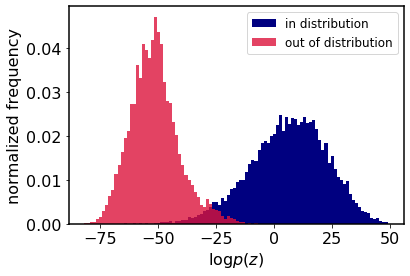

omniglot
AUROC: 0.973


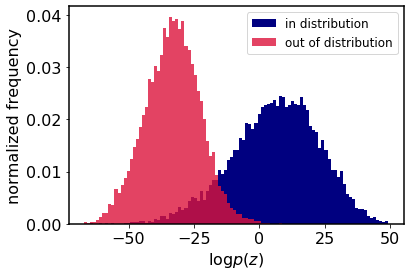

mnistvertical
AUROC: 0.997


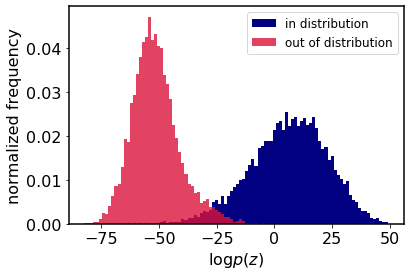

mnisthorizontal
AUROC: 0.996


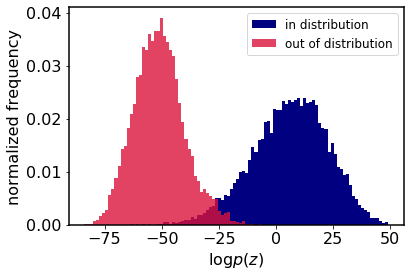

fmnistvertical
AUROC: 0.861


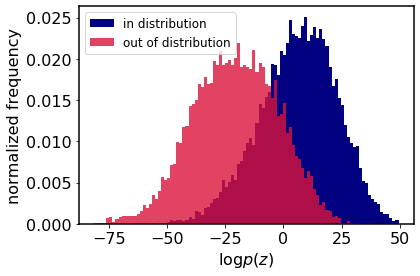

fmnisthorizontal
AUROC: 0.681


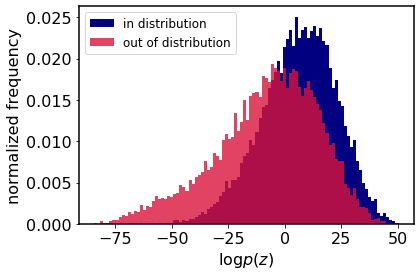

In [12]:

for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    print(ood_set)

    logps_ood = np.load(os.path.join(path,'logp_%s.npy'%ood_set))
    compute_AUROC(logps,logps_ood)
    mini = min(min(np.sort(logps)[2:]),min(np.sort(logps_ood)[2:]))
    maxi = max(max(logps),max(logps_ood))
    plt.figure()
    _ = plt.hist(logps, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(logps_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(r'$\mathrm{log} p(z)$')
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+'_'+'GIS_logp'+'.pdf'),bbox_inches='tight')
    plt.show()

In [26]:
kde = pickle.load(open('kde_fit.pkl', 'rb'))
data_dir = '/global/cscratch1/sd/vboehm/Datasets'

In [27]:
for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    data = np.load(os.path.join(data_dir,ood_set+'_AE40_encoded.npy'))
    logps= kde.score_samples(data)
    np.save(os.path.join(data_dir,'logp_%s.npy'%ood_set),logps)


In [28]:
logps= kde.score_samples(encodeds)
np.save(os.path.join(data_dir,'logp_%s.npy'%'fmnist'), logps)

In [29]:
logps

array([ 12.19277512, -32.56996725,  12.69913931, ..., -15.99054189,
        15.02293271,   6.67547615])

mnist
AUROC: 0.895


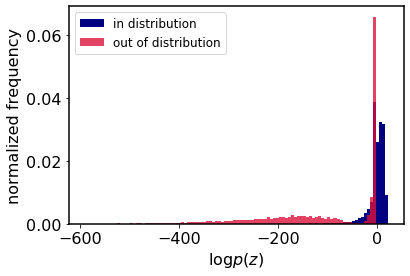

omniglot
AUROC: 0.864


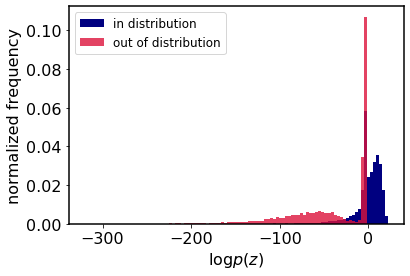

mnistvertical
AUROC: 0.896


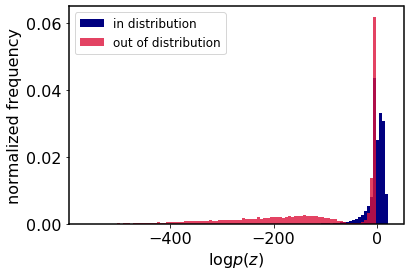

mnisthorizontal
AUROC: 0.899


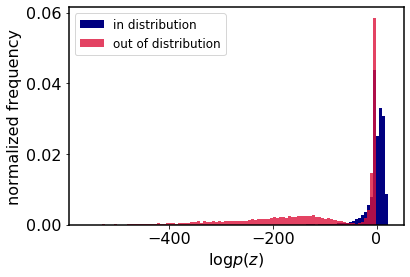

fmnistvertical
AUROC: 0.799


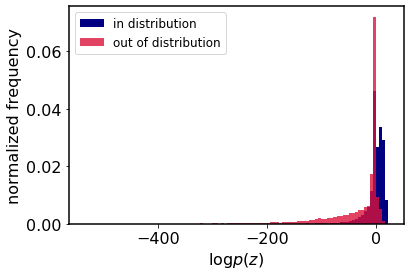

fmnisthorizontal
AUROC: 0.659


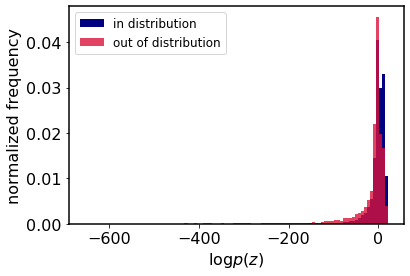

In [32]:
for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    print(ood_set)

    logps_ood = np.load(os.path.join(data_dir,'logp_%s.npy'%ood_set))
    compute_AUROC(logps,logps_ood)
    mini = min(min(np.sort(logps)[2:]),min(np.sort(logps_ood)[2:]))
    maxi = max(max(logps),max(logps_ood))
    plt.figure()
    _ = plt.hist(logps, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(logps_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(r'$\mathrm{log} p(z)$')
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+'_'+'KDE_logp'+'.pdf'),bbox_inches='tight')
    plt.show()